# Model Pruning Demo using MNIST and a toy CNN model

Some intro...

## Environment setup

We first install fundemental packages and download the MNIST dataset and a pretrained model.

In [1]:
!python -m pip install torchprofile matplotlib tqdm > /dev/null

In [2]:
import copy
import math
import numpy
import random
import time
import torch
import torchprofile
import torchvision

from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
random.seed(7)
numpy.random.seed(7)
torch.manual_seed(7)

## Dataset

We directly use MNIST in `torchvision`.

In [4]:
trMNIST = torchvision.datasets.MNIST(root='./data/train', train=True, download=True, transform=torchvision.transforms.ToTensor())
vaMNIST = torchvision.datasets.MNIST(root='./data/valid', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [5]:
print('# of img for training:', len(trMNIST))
print('# of img for validation:', len(vaMNIST))

# of img for training: 60000
# of img for validation: 10000


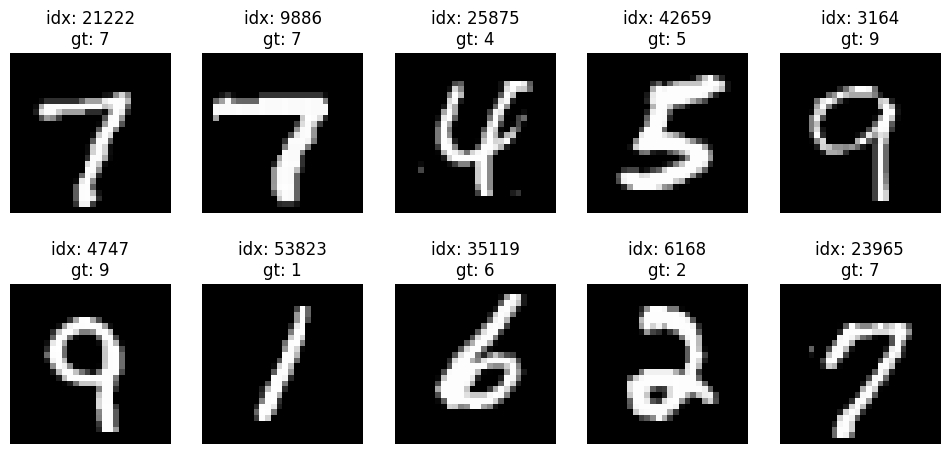

In [6]:
nPlot = 10
idx = random.sample(range(len(trMNIST)), nPlot)
plt.figure(figsize=(12, 5.5))
for i in range(nPlot):
    plt.subplot(2, 5, i+1)
    plt.imshow(trMNIST[idx[i]][0].permute(1, 2, 0), cmap='gray')
    plt.title(f'idx: {idx[i]:d}\ngt: {trMNIST[idx[i]][1]:d}')
    plt.axis('off')

Create data loaders for training and validation sets.

In [7]:
trLoader = torch.utils.data.DataLoader(trMNIST, batch_size=256, shuffle=True, pin_memory=True)
vaLoader = torch.utils.data.DataLoader(vaMNIST, batch_size=1024, shuffle=False, pin_memory=True)

## Define fundamental functions

In [8]:
def Train(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    callbacks = None) -> None:

    model.train()
    for inputs, targets in tqdm(dataloader, desc='train', leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Reset the gradients (from the last iteration)
        optimizer.zero_grad()

        # Forward inference
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward propagation
        loss.backward()

        # Update optimizer
        optimizer.step()

        if callbacks is not None:
            for callback in callbacks:
                callback()

In [9]:
@torch.inference_mode()
def Valid(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    verbose=True) -> float:

    model.eval()

    num_samples = 0
    num_correct = 0
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="eval", leave=False, disable=not verbose):
            # Move the data from CPU to GPU
            inputs = inputs.cuda()
            argets = targets.cuda()

            # Inference
            outputs = model(inputs)

            # Convert logits to class indices
            outputs = outputs.argmax(dim=1)

            # Update metrics
            num_samples += targets.size(0)
            num_correct += (outputs.cpu() == targets).sum()

        return (num_correct / num_samples * 100).item()

Some helper functions...

In [10]:
def GetModelMACs(model, inputs) -> int:
    return torchprofile.profile_macs(model, inputs)


def GetSparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def GetModelSparsity(model: torch.nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def GetNParam(model: torch.nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def GetModelSize(model: torch.nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return GetNParam(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

## Define neural network

A toy CNN network.

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1) # 1 x 32 x 3 x 3 = 288 parameters
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1) # 32 x 64 x 3 x 3=18,432 paramters
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128) # 9216 x 128 = 1,179,648 parameters
        self.fc2 = torch.nn.Linear(128, 10) # 128 x 10 = 1,280 parameters

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output

In [12]:
model = Net().cuda()

## Train the CNN model on MNIST

In [13]:
lr = 1.0
lr_step_gamma = 0.7
num_epochs = 5

optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
criterion = torch.nn.functional.nll_loss
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_accuracy = 0
best_checkpoint = dict()
for epoch in range(num_epochs):
    Train(model, trLoader, criterion, optimizer)
    accuracy = Valid(model, vaLoader)
    scheduler.step()
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'Epoch {epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])

train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  1 Accuracy 97.80% / Best Accuracy: 97.80%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  2 Accuracy 98.59% / Best Accuracy: 98.59%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  3 Accuracy 98.72% / Best Accuracy: 98.72%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  4 Accuracy 98.88% / Best Accuracy: 98.88%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  5 Accuracy 98.92% / Best Accuracy: 98.92%
=> loading best checkpoint


<All keys matched successfully>

In [14]:
recover_model = lambda: model.load_state_dict(best_checkpoint['state_dict'])

## Evaluate the trained *dense* model

In [15]:
denseNNAcc = Valid(model, vaLoader)
denseNNSize = GetModelSize(model)
denseNNMACs = GetModelMACs(model, torch.randn(1, 1, 28, 28).cuda())
denseNNSpar = GetModelSparsity(model)
print(f"Dense model accuracy: {denseNNAcc:.2f}%")
print(f"                size: {denseNNSize/MiB:.2f} MiB")

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Dense model accuracy: 98.92%
                size: 4.58 MiB


In [16]:
def InferenceOneImg(model, img):
    res = model(img[None, :, :, :].cuda()).argmax(dim=1)
    return int(res.cpu())

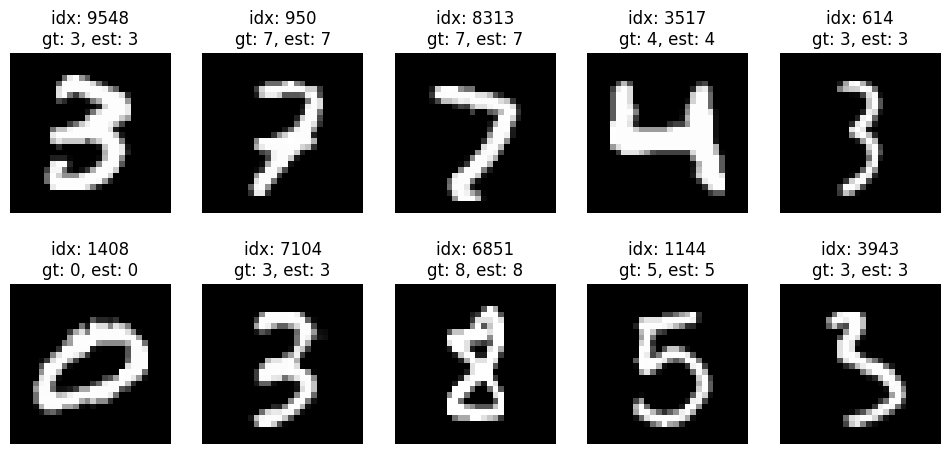

In [17]:
nPlot = 10
idx = random.sample(range(len(vaMNIST)), nPlot)
plt.figure(figsize=(12, 5.5))
for i in range(nPlot):
    plt.subplot(2, 5, i+1)
    plt.imshow(vaMNIST[idx[i]][0].permute(1, 2, 0), cmap='gray')
    plt.title(f'idx: {idx[i]:d}\ngt: {vaMNIST[idx[i]][1]:d}, est: {InferenceOneImg(model, vaMNIST[idx[i]][0]):d}')
    plt.axis('off')

## Analysis on the NN weights

In [18]:
def plot_weight_distribution(model, bins=128, count_nonzero_only=False):
    fig, axes = plt.subplots(2,2, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

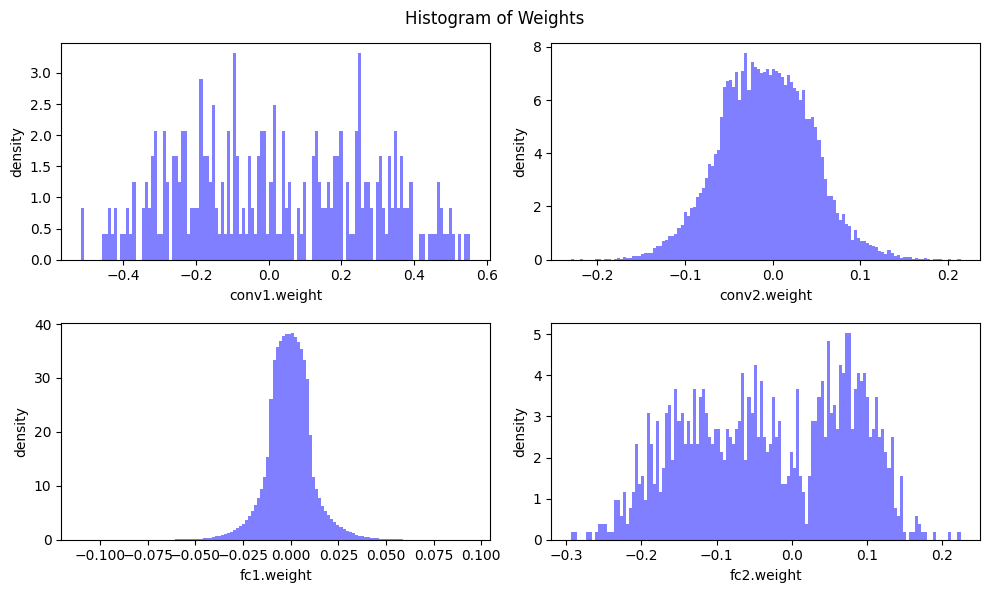

In [19]:
plot_weight_distribution(model)

## Pruning

In [20]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = round(num_elements * sparsity)
    importance = torch.abs(tensor)
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    mask = importance > threshold
    tensor.mul_(mask)

    return mask

In [21]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity):    
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity)
        return masks

In [22]:
sparsity = 0.8
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)

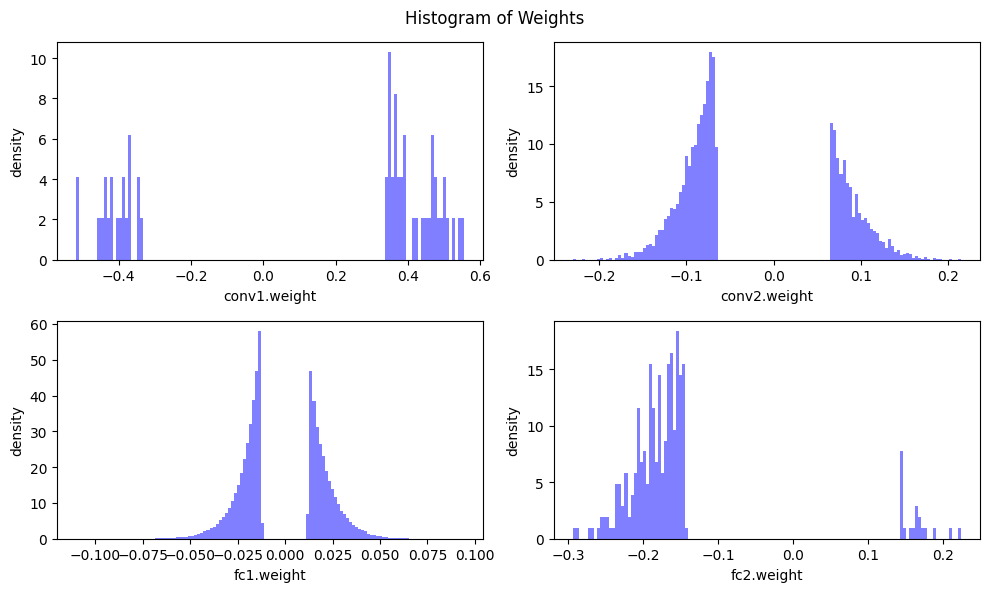

In [23]:
plot_weight_distribution(model, count_nonzero_only=True)

## Evaluate the pruned model

pruned, sparse, not finetuned

In [24]:
sparseNNAcc = Valid(model, vaLoader)
sparseNNSize = GetModelSize(model, count_nonzero_only=True)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
print(f"{sparsity*100}% sparse NN accuracy: {sparseNNAcc:.2f}%\t{denseNNAcc-sparseNNAcc:.2f}% drop...")
print(f"                    size: {sparseNNSize/MiB:.2f} MiB\t{denseNNSize/sparseNNSize:.2f}X smaller than the dense NN")

80.0% sparse NN accuracy: 52.77%	46.15% drop...
                    size: 0.92 MiB	5.00X smaller than the dense NN


## Finetuning the pruned model for accuracy recovery

finetune the pruned model and keep the model sparsity

In [26]:
num_finetune_epochs = 3
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # apply the pruning mask at the end of each train iteration
    # to keep the model sparse during the training
    Train(model, trLoader, criterion, optimizer, callbacks=[lambda: pruner.apply(model)])
    accuracy = Valid(model, vaLoader)
    scheduler.step()
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Sparse Accuracy 98.53% / Best Sparse Accuracy: 98.53%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 Sparse Accuracy 98.77% / Best Sparse Accuracy: 98.77%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 Sparse Accuracy 98.89% / Best Sparse Accuracy: 98.89%


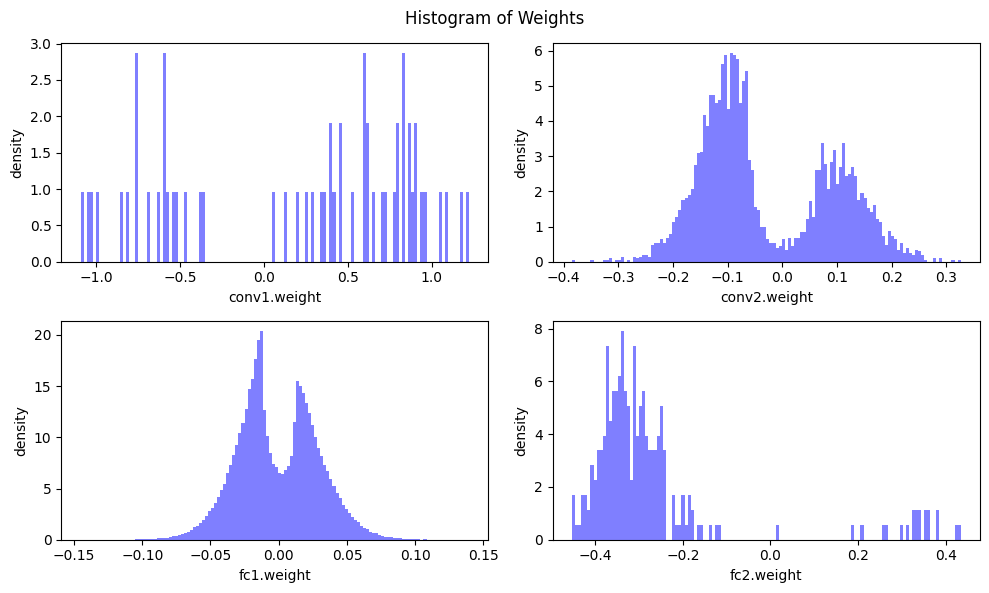

In [27]:
plot_weight_distribution(model, count_nonzero_only=True)

## Evaluate The Finetuned Pruned Model

In [28]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparseNNAcc = Valid(model, vaLoader)
sparseNNSize = GetModelSize(model, count_nonzero_only=True)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
print(f"{sparsity*100}% sparse NN accuracy: {sparseNNAcc:.2f}%\t{denseNNAcc-sparseNNAcc:.2f}% drop...")
print(f"                    size: {sparseNNSize/MiB:.2f} MiB\t{denseNNSize/sparseNNSize:.2f}X smaller than the dense NN")

80.0% sparse NN accuracy: 98.89%	0.03% drop...
                    size: 0.92 MiB	5.00X smaller than the dense NN


The accuracy is (mostly) recovered. Better and faster...